In [1]:
import torch
from performer_pytorch import PerformerLM
import scanpy as sc
import anndata as ad
from utils import *
import pickle as pkl
from tqdm.notebook import tqdm
import zarr

In [2]:
CLASS = 7
SEED = 2021
EPOCHS = 1
SEQ_LEN = 16906 + 1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
data_path = 'data/low_feature.h5ad'
adata = sc.read_h5ad(data_path)
data = adata.X
print(type(data))
data.shape

<class 'scipy.sparse._csr.csr_matrix'>


(36712, 400)

In [7]:
model = PerformerLM(
    num_tokens = CLASS,
    dim = 200,
    depth = 6,
    max_seq_len = SEQ_LEN,
    heads = 10,
    local_attn_heads = 0,
    g2v_position_emb = True
)

path = 'model/scbert_pretrain.pth'
ckpt = torch.load(path, map_location=torch.device('cpu'))
model.load_state_dict(ckpt['model_state_dict'])
for param in model.parameters():
    param.requires_grad = False
model = model.to(device)

In [8]:
def scbert_embed(data):
    batch_size = data.shape[0]
    model.eval()
    batch = []
    epoch = []
    with torch.no_grad():
        for index in tqdm(range(batch_size)):
            full_seq = data[index].toarray()[0]
            full_seq[full_seq > (CLASS - 2)] = CLASS - 2
            full_seq = torch.from_numpy(full_seq).long()
            full_seq = torch.cat((full_seq, torch.tensor([0]))).to(device)
            full_seq = full_seq.unsqueeze(0)
            cell_embedding = model(full_seq, return_encodings = True)
            batch.append(cell_embedding)
            if index % 500 == 0:
                #regularly empty GPU of data
                epoch.extend([b.cpu() for b in batch])
                batch = []
        epoch.extend([b.cpu() for b in batch])
    embeddings = np.stack([t.numpy().astype(np.float16) for t in epoch])
    return embeddings

def get_cuts(N, k):
    return [i * N // k for i in range(1, k)]

In [ ]:
number_of_batch = 3
batch_cut = get_cuts(36712, number_of_batch)
for i in range(number_of_batch):
    print(i)
    if i == 0:
        batch_data = data[:batch_cut[i]]
        print(f'batch : {0}-{batch_cut[i]}')
    elif i == len(batch_cut):
        batch_data = data[batch_cut[i-1]:]
        print(f'batch : {batch_cut[i-1]}-{data.shape[0]}')
    else:
        batch_data = data[batch_cut[i-1]:batch_cut[i]]
        print(f'batch : {batch_cut[i-1]}-{batch_cut[i]}')
    embeddings = scbert_embed(batch_data)
    print(embeddings.shape)
    path = 'data/embeddings_' + str(i) + '.npy'
    np.save(path, embeddings)
      

0
batch : 0-12237


  0%|          | 0/12237 [00:00<?, ?it/s]

(12237, 1, 401, 200)
1
batch : 12237-24474


  0%|          | 0/12237 [00:00<?, ?it/s]

(12237, 1, 401, 200)
2
batch : 24474-36712


  0%|          | 0/12238 [00:00<?, ?it/s]

/home/agauthier/jupyter/lib/python3.10/site-packages/anndata/_core/anndata.py:787: ImplicitModificationWarning: Trying to modify index of attribute `.obs` of view, initializing view as actual.
  getattr(self, attr).index = value
/home/agauthier/jupyter/lib/python3.10/site-packages/anndata/_core/anndata.py:787: ImplicitModificationWarning: Trying to modify index of attribute `.obs` of view, initializing view as actual.
  getattr(self, attr).index = value


AnnData object with n_obs × n_vars = 2000 × 80200
    obs: 'cell1', 'cell2', 'fraction', 'sample', 'cell_ID', 'n_genes', 'leiden'
    uns: 'log1p'

In [22]:
aembed.obsm['X_pca']

array([[ 93.49694  , -85.514404 ,  25.808191 , ...,  -3.7434633,
          1.9561622,   9.652827 ],
       [-78.892914 ,  14.199752 ,  30.795286 , ...,  15.221794 ,
         -5.5154853,  -4.2803183],
       [-32.27391  ,  28.841232 ,  32.584194 , ...,   2.6190875,
          7.9683523,   3.778545 ],
       ...,
       [ 29.670645 , -28.547829 ,  65.34912  , ..., -17.805716 ,
         11.8345585,  14.788851 ],
       [119.48746  , -50.290825 ,  -8.392629 , ...,  15.644132 ,
         -7.463482 ,  -9.058985 ],
       [ 88.93688  , -58.8386   ,  43.5524   , ...,  -1.9753696,
         18.824356 ,   5.143198 ]], shape=(2000, 50), dtype=float32)

/home/agauthier/jupyter/lib/python3.10/site-packages/scanpy/tools/_utils.py:40: UserWarning: You’re trying to run this on 3381400 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  warnings.warn(


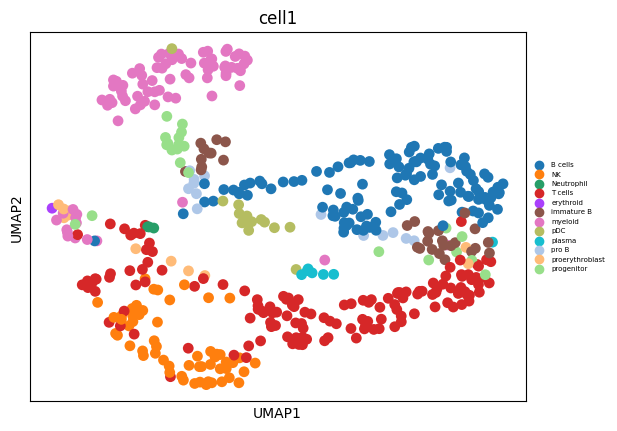

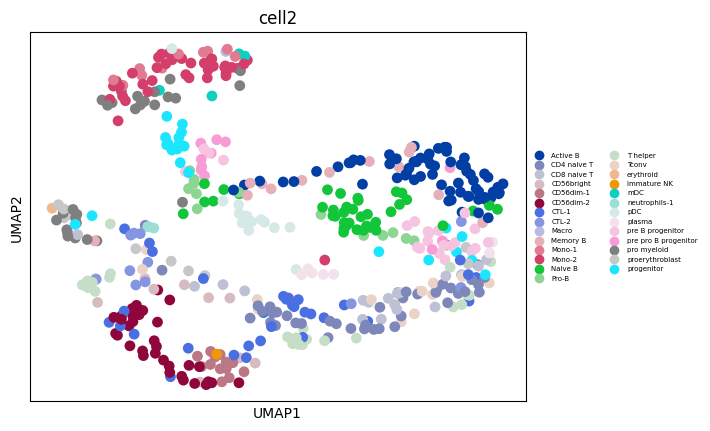

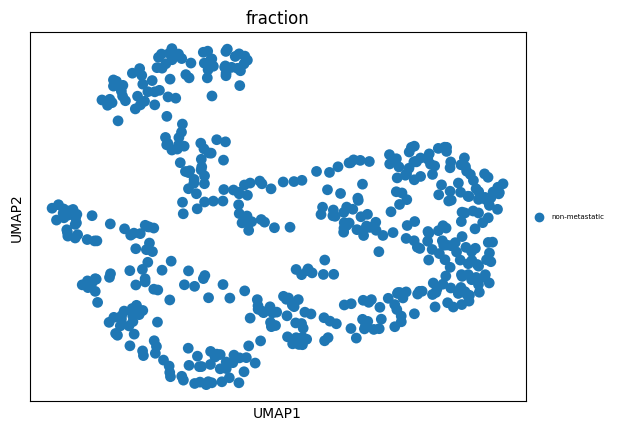

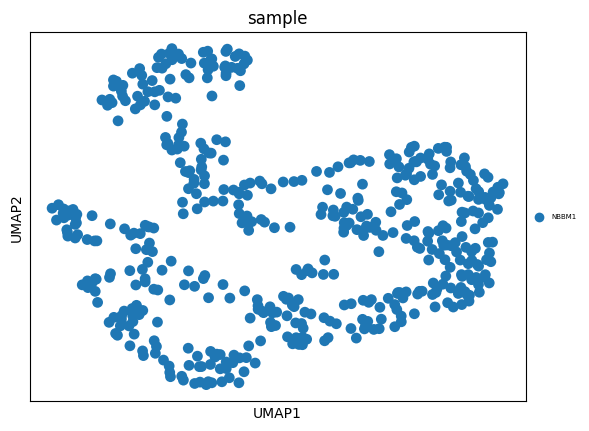

In [27]:
sc.pp.neighbors(aembed, use_rep='X')
sc.tl.umap(aembed)

for feature in ["cell1", "cell2", "fraction", "sample"]:
    sc.pl.umap(aembed, color=feature, legend_fontsize=5)

In [ ]:
with lzma.open('./data/embeddings_1000.xz', 'rb') as f:
    embeddings = pickle.load(f)
embeddings

In [ ]:
print(len(embeddings))
print(embeddings[0].size())